In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import warnings
import sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost
import dill
import sys

# Check Python version
print("Python version:", sys.version)

# Check versions of libraries
print("Python version:", pd.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgb.__version__)
print("LightGBM version:", lgb.__version__)
print("CatBoost version:", catboost.__version__)
print("Dill version:", dill.__version__)

Python version: 3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Python version: 2.2.2
Pandas version: 2.2.2
NumPy version: 1.26.4
Seaborn version: 0.13.2
Matplotlib version: 3.9.2
Scikit-learn version: 1.5.1
XGBoost version: 2.1.1
LightGBM version: 4.5.0
CatBoost version: 1.2.5
Dill version: 0.3.8


#### My System Modules versions

Python version: `3.11.9` [MSC v.1916 64 bit (AMD64)]

Python version: `2.2.2`

Pandas version: `2.2.2`

NumPy version: `1.26.4`

Seaborn version: `0.13.2`

Matplotlib version: `3.9.2`

Scikit-learn version: `1.5.1`

XGBoost version: `2.1.1`

LightGBM version: `4.5.0`

CatBoost version: `1.2.5`

Dill version: `0.3.8`

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, log_loss, balanced_accuracy_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import FunctionTransformer

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline

import dill

from sklearn.metrics import RocCurveDisplay

In [63]:
x_train_final = pd.read_csv("X_Train_Data_Input.csv")
y_train_final = pd.read_csv("Y_Train_Data_Target.csv")
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(x_train_final, y_train_final, test_size=0.2, random_state=42, stratify=y_train_final['target'])

x_train_final.reset_index(drop=True, inplace=True)
x_val_final.reset_index(drop=True, inplace=True)
y_train_final.reset_index(drop=True, inplace=True)
y_val_final.reset_index(drop=True, inplace=True)

x_test_final = pd.read_csv("X_Test_Data_Input.csv")
y_test_final = pd.read_csv("Y_Test_Data_Target.csv")

In [64]:
class CustomVotingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, models):
        self.models = models  # Dictionary of model names and instances
        self.model_names = list(models.keys())

    def _convert_to_dataframe(self, X, y=None):
        """Helper function to convert input to DataFrame if it's not already one."""
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if y is not None and not isinstance(y, pd.DataFrame):
            y = pd.DataFrame(y)
        return X, y

    def fit(self, X, y):
        
        X, y = self._convert_to_dataframe(X, y)
            
        # Fit each model
        for model in self.models.values():
            model.fit(X, y)
            
        self.fitted_ = True 
        return self

    def predict(self, X):
        # Convert X to DataFrame if needed
        X, _ = self._convert_to_dataframe(X)

        # Get predictions from each model
        predictions = np.array([model.predict(X) for model in self.models.values()])
        
        # Use majority voting
        return np.round(np.mean(predictions, axis=0)).astype(int)

    def predict_proba(self, X):
        # Convert X to DataFrame if needed
        X, _ = self._convert_to_dataframe(X)

        # Get probabilities from each model
        probabilities = np.array([model.predict_proba(X) for model in self.models.values()])
        
        # Average probabilities
        return np.mean(probabilities, axis=0)

In [65]:
# Function to drop specified columns
def drop_columns(X):
    return X.drop(columns=['ID', 'Column9'])

# Create the FunctionTransformer
drop_columns_transformer = FunctionTransformer(drop_columns)

In [66]:
imputer = SimpleImputer(strategy='median')
sc = StandardScaler()

In [67]:
# Model parameters
xgb_params = {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}
lightbgm_params = {'lambda_l1': 3.962980604776118, 'lambda_l2': 1.5075196212131254, 'num_leaves': 90, 'feature_fraction': 0.9675647296514234, 'bagging_fraction': 0.9979919873256766, 'bagging_freq': 2, 'min_child_samples': 63}
catboost_params = {
    'iterations': 700,
    'learning_rate': 0.12851432422429102,
    'l2_leaf_reg': 0.8373406120034129,
    'border_count': 171,
    'bagging_temperature': 22.360639700244604,
    'random_strength': 1.3991869546371338,
    'boosting_type': 'Plain',
    'depth': 9,
    'grow_policy': 'SymmetricTree',
    'eval_metric': 'F1', 
}

# Initialize models
models = {
    'XGBClassifier': XGBClassifier(**xgb_params),
    'CatBoostClassifier': CatBoostClassifier(**catboost_params, verbose=False),
    'LGBMClassifier': LGBMClassifier(**lightbgm_params, verbose=-1)
}

In [68]:
final_models = {
    'XGBClassifier': models['XGBClassifier'],    # Replace with your actual XGBClassifier object
    'CatBoostClassifier': models['CatBoostClassifier'],  # Replace with your actual CatBoostClassifier object
    'LGBMClassifier': models['LGBMClassifier']   # Replace with your actual LGBMClassifier object
}

In [69]:
voting_clf = CustomVotingClassifier(models=final_models)

In [70]:
# Pipeline
pipeline = Pipeline([
    ('drop_columns', drop_columns_transformer),  # Drop specified columns
    ('imputer', imputer),                        # Impute missing values
    ('scaler', sc),                             # Scale the data
    ('voting', voting_clf)                      # Train the voting classifier
])

In [71]:
# Assuming 'pipeline' is your pipeline object
with open('best_pipeline_model.pkl', 'wb') as f:
    dill.dump(pipeline, f)

In [72]:
with open('best_pipeline_model.pkl', 'rb') as f:
    loaded = dill.load(f)

In [73]:
loaded

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_columns at 0x0000020E176E7CE0>)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('voting',
                 CustomVotingClassifier(models={'CatBoostClassifier': <catboost.core.CatBoostClassifier object at 0x0000020E387852D0>,
                                                'LGBMClassifier': LGBMClassifier(bagging_fraction=0.9...
                                                                               grow_policy=None,
                                                                               importance_type=None,
                                                                               interaction_constraints=None,
                                                                               learning_rate=0.1,
                                                                               max_bin=None,
                                                                               max_cat_threshold=None,
                                                                               max_cat_to_onehot=None,
                                                                               max_delta_step=None,
                                                                               max_depth=7,
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=200,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None,
                                                                               random_state=None, ...)}))])

In [74]:
loaded.fit(x_train_final, y_train_final.iloc[:, -1])

Pipeline(steps=[('drop_columns',
                 FunctionTransformer(func=<function drop_columns at 0x0000020E176E7CE0>)),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('voting',
                 CustomVotingClassifier(models={'CatBoostClassifier': <catboost.core.CatBoostClassifier object at 0x0000020E387852D0>,
                                                'LGBMClassifier': LGBMClassifier(bagging_fraction=0.9...
                                                                               grow_policy=None,
                                                                               importance_type=None,
                                                                               interaction_constraints=None,
                                                                               learning_rate=0.1,
                                                                               max_bin=None,
                                                                               max_cat_threshold=None,
                                                                               max_cat_to_onehot=None,
                                                                               max_delta_step=None,
                                                                               max_depth=7,
                                                                               max_leaves=None,
                                                                               min_child_weight=None,
                                                                               missing=nan,
                                                                               monotone_constraints=None,
                                                                               multi_strategy=None,
                                                                               n_estimators=200,
                                                                               n_jobs=None,
                                                                               num_parallel_tree=None,
                                                                               random_state=None, ...)}))])

In [75]:
y_pred_train = loaded.predict(x_train_final)
y_pred_train

array([0, 0, 1, ..., 1, 0, 0])

In [76]:
y_prob_train = loaded.predict_proba(x_train_final)
y_prob_train

array([[9.99995856e-01, 4.14564952e-06],
       [9.99994320e-01, 5.68906590e-06],
       [6.44774496e-02, 9.35522550e-01],
       ...,
       [1.28537977e-01, 8.71462023e-01],
       [9.99994277e-01, 5.72864081e-06],
       [9.99995876e-01, 4.11993685e-06]])

In [77]:
# Calculate evaluation metrics for the training data
accuracy_train = accuracy_score(y_train_final['target'], y_pred_train)
precision_train = precision_score(y_train_final['target'], y_pred_train)
recall_train = recall_score(y_train_final['target'], y_pred_train)
f1_train = f1_score(y_train_final['target'], y_pred_train)
roc_auc_train = roc_auc_score(y_train_final['target'], y_pred_train)
balanced_acc_train = balanced_accuracy_score(y_train_final['target'], y_pred_train)
log_loss_train = log_loss(y_train_final['target'], y_prob_train)
conf_matrix_train = confusion_matrix(y_train_final['target'], y_pred_train)
class_report_train = classification_report(y_train_final['target'], y_pred_train)

# Print the evaluation results for training data
print('\tTraining Results\n')
print(f"Accuracy: {accuracy_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")
print(f"ROC AUC Score: {roc_auc_train}")
print(f"Balanced Accuracy: {balanced_acc_train}")
print(f"Log Loss: {log_loss_train}")
print("\nConfusion Matrix:")
print(conf_matrix_train)
print("\nClassification Report:")
print(class_report_train)

	Training Results

Accuracy: 0.981929801657682
Precision: 0.8691743006076309
Recall: 0.9515922061256881
F1 Score: 0.9085179095334817
ROC AUC Score: 0.9683402248459969
Balanced Accuracy: 0.9683402248459969
Log Loss: 0.04155323916275653

Confusion Matrix:
[[560397   8483]
 [  2867  56359]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    568880
           1       0.87      0.95      0.91     59226

    accuracy                           0.98    628106
   macro avg       0.93      0.97      0.95    628106
weighted avg       0.98      0.98      0.98    628106



In [78]:
y_pred_val = loaded.predict(x_val_final)
y_pred_val

array([0, 0, 0, ..., 1, 0, 0])

In [79]:
y_prob_val = loaded.predict_proba(x_val_final)
y_prob_val

array([[9.99995835e-01, 4.16691722e-06],
       [9.99994301e-01, 5.69360071e-06],
       [9.99995706e-01, 4.28854632e-06],
       ...,
       [1.07533661e-01, 8.92466339e-01],
       [9.99995714e-01, 4.28740703e-06],
       [9.99994388e-01, 5.60543423e-06]])

In [80]:
# Calculate evaluation metrics
accuracy_val = accuracy_score(y_val_final['target'], y_pred_val)
precision_val = precision_score(y_val_final['target'], y_pred_val)
recall_val = recall_score(y_val_final['target'], y_pred_val)
f1_val = f1_score(y_val_final['target'], y_pred_val)
roc_auc_val = roc_auc_score(y_val_final['target'], y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val_final['target'], y_pred_val)
log_loss_val = log_loss(y_val_final['target'], y_prob_val)
conf_matrix_val = confusion_matrix(y_val_final['target'], y_pred_val)
class_report_val = classification_report(y_val_final['target'], y_pred_val)

# Print the evaluation results
print('\tValidation Results\n')
print(f"Accuracy: {accuracy_val}")
print(f"Precision: {precision_val}")
print(f"Recall: {recall_val}")
print(f"F1 Score: {f1_val}")
print(f"ROC AUC Score: {roc_auc_val}")
print(f"Balanced Accuracy: {balanced_acc_val}")
print(f"Log Loss: {log_loss_val}")
print("\nConfusion Matrix:")
print(conf_matrix_val)
print("\nClassification Report:")
print(class_report_val)

	Validation Results

Accuracy: 0.9786788259343935
Precision: 0.8546140991520703
Recall: 0.9325319105828325
F1 Score: 0.8918744348275417
ROC AUC Score: 0.9580076231299762
Balanced Accuracy: 0.9580076231299762
Log Loss: 0.048846078664091026

Confusion Matrix:
[[139871   2349]
 [   999  13808]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    142220
           1       0.85      0.93      0.89     14807

    accuracy                           0.98    157027
   macro avg       0.92      0.96      0.94    157027
weighted avg       0.98      0.98      0.98    157027



In [81]:
y_pred_test_final = loaded.predict(x_test_final)
y_pred_test_final

array([0, 0, 0, ..., 0, 0, 0])

In [82]:
y_prob_test_final = loaded.predict_proba(x_test_final)
y_prob_test_final

array([[9.99994576e-01, 5.42752856e-06],
       [9.99994553e-01, 5.44927707e-06],
       [9.99994380e-01, 5.62877378e-06],
       ...,
       [9.99994575e-01, 5.43232965e-06],
       [9.99994360e-01, 5.64881812e-06],
       [9.99994148e-01, 5.84235916e-06]])

In [83]:
# Calculate evaluation metrics
accuracy_test = accuracy_score(y_test_final['target'], y_pred_test_final)
precision_test = precision_score(y_test_final['target'], y_pred_test_final)
recall_test = recall_score(y_test_final['target'], y_pred_test_final)
f1_test = f1_score(y_test_final['target'], y_pred_test_final)
roc_auc_test = roc_auc_score(y_test_final['target'], y_pred_test_final)
balanced_acc_test = balanced_accuracy_score(y_test_final['target'], y_pred_test_final)
log_loss_test = log_loss(y_test_final['target'], y_prob_test_final)
conf_matrix_test = confusion_matrix(y_test_final['target'], y_pred_test_final)
class_report_test = classification_report(y_test_final['target'], y_pred_test_final)

# Print the evaluation results
print('\tTesting Results\n')
print(f"Accuracy: {accuracy_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")
print(f"ROC AUC Score: {roc_auc_test}")
print(f"Balanced Accuracy: {balanced_acc_test}")
print(f"Log Loss: {log_loss_test}")
print("\nConfusion Matrix:")
print(conf_matrix_test)
print("\nClassification Report:")
print(class_report_test)

	Testing Results

Accuracy: 0.9785680442623953
Precision: 0.8503656340719509
Recall: 0.937717805332685
F1 Score: 0.8919080380027365
ROC AUC Score: 0.9602694176135653
Balanced Accuracy: 0.9602694176135653
Log Loss: 0.049076202121271076

Confusion Matrix:
[[232962   4072]
 [  1537  23141]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    237034
           1       0.85      0.94      0.89     24678

    accuracy                           0.98    261712
   macro avg       0.92      0.96      0.94    261712
weighted avg       0.98      0.98      0.98    261712



In [84]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Get feature importances from each model
xgb_importance = loaded.named_steps['voting'].models['XGBClassifier'].feature_importances_
cat_importance = loaded.named_steps['voting'].models['CatBoostClassifier'].get_feature_importance()
lgb_importance = loaded.named_steps['voting'].models['LGBMClassifier'].feature_importances_

# Step 2: Normalize the importances
scaler = MinMaxScaler()
xgb_importance = scaler.fit_transform(xgb_importance.reshape(-1, 1)).flatten()
cat_importance = scaler.fit_transform(cat_importance.reshape(-1, 1)).flatten()
lgb_importance = scaler.fit_transform(lgb_importance.reshape(-1, 1)).flatten()

# Step 3: Combine the importances (using average here)
avg_importance = (xgb_importance + cat_importance + lgb_importance) / 3

# Step 4: Create DataFrame for visualization
columns = ['Column0', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5',
       'Column6', 'Column7', 'Column8', 'Column10', 'Column11', 'Column12', 'Column13',
       'Column14', 'Column15', 'Column16', 'Column17', 'Column18', 'Column19',
       'Column20', 'Column21']

feature_names = columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
17,Column18,0.725690
1,Column1,0.364509
2,Column2,0.298605
7,Column7,0.186993
8,Column8,0.155464
13,Column14,0.122809
3,Column3,0.109014
4,Column4,0.105901
6,Column6,0.075759
5,Column5,0.071232


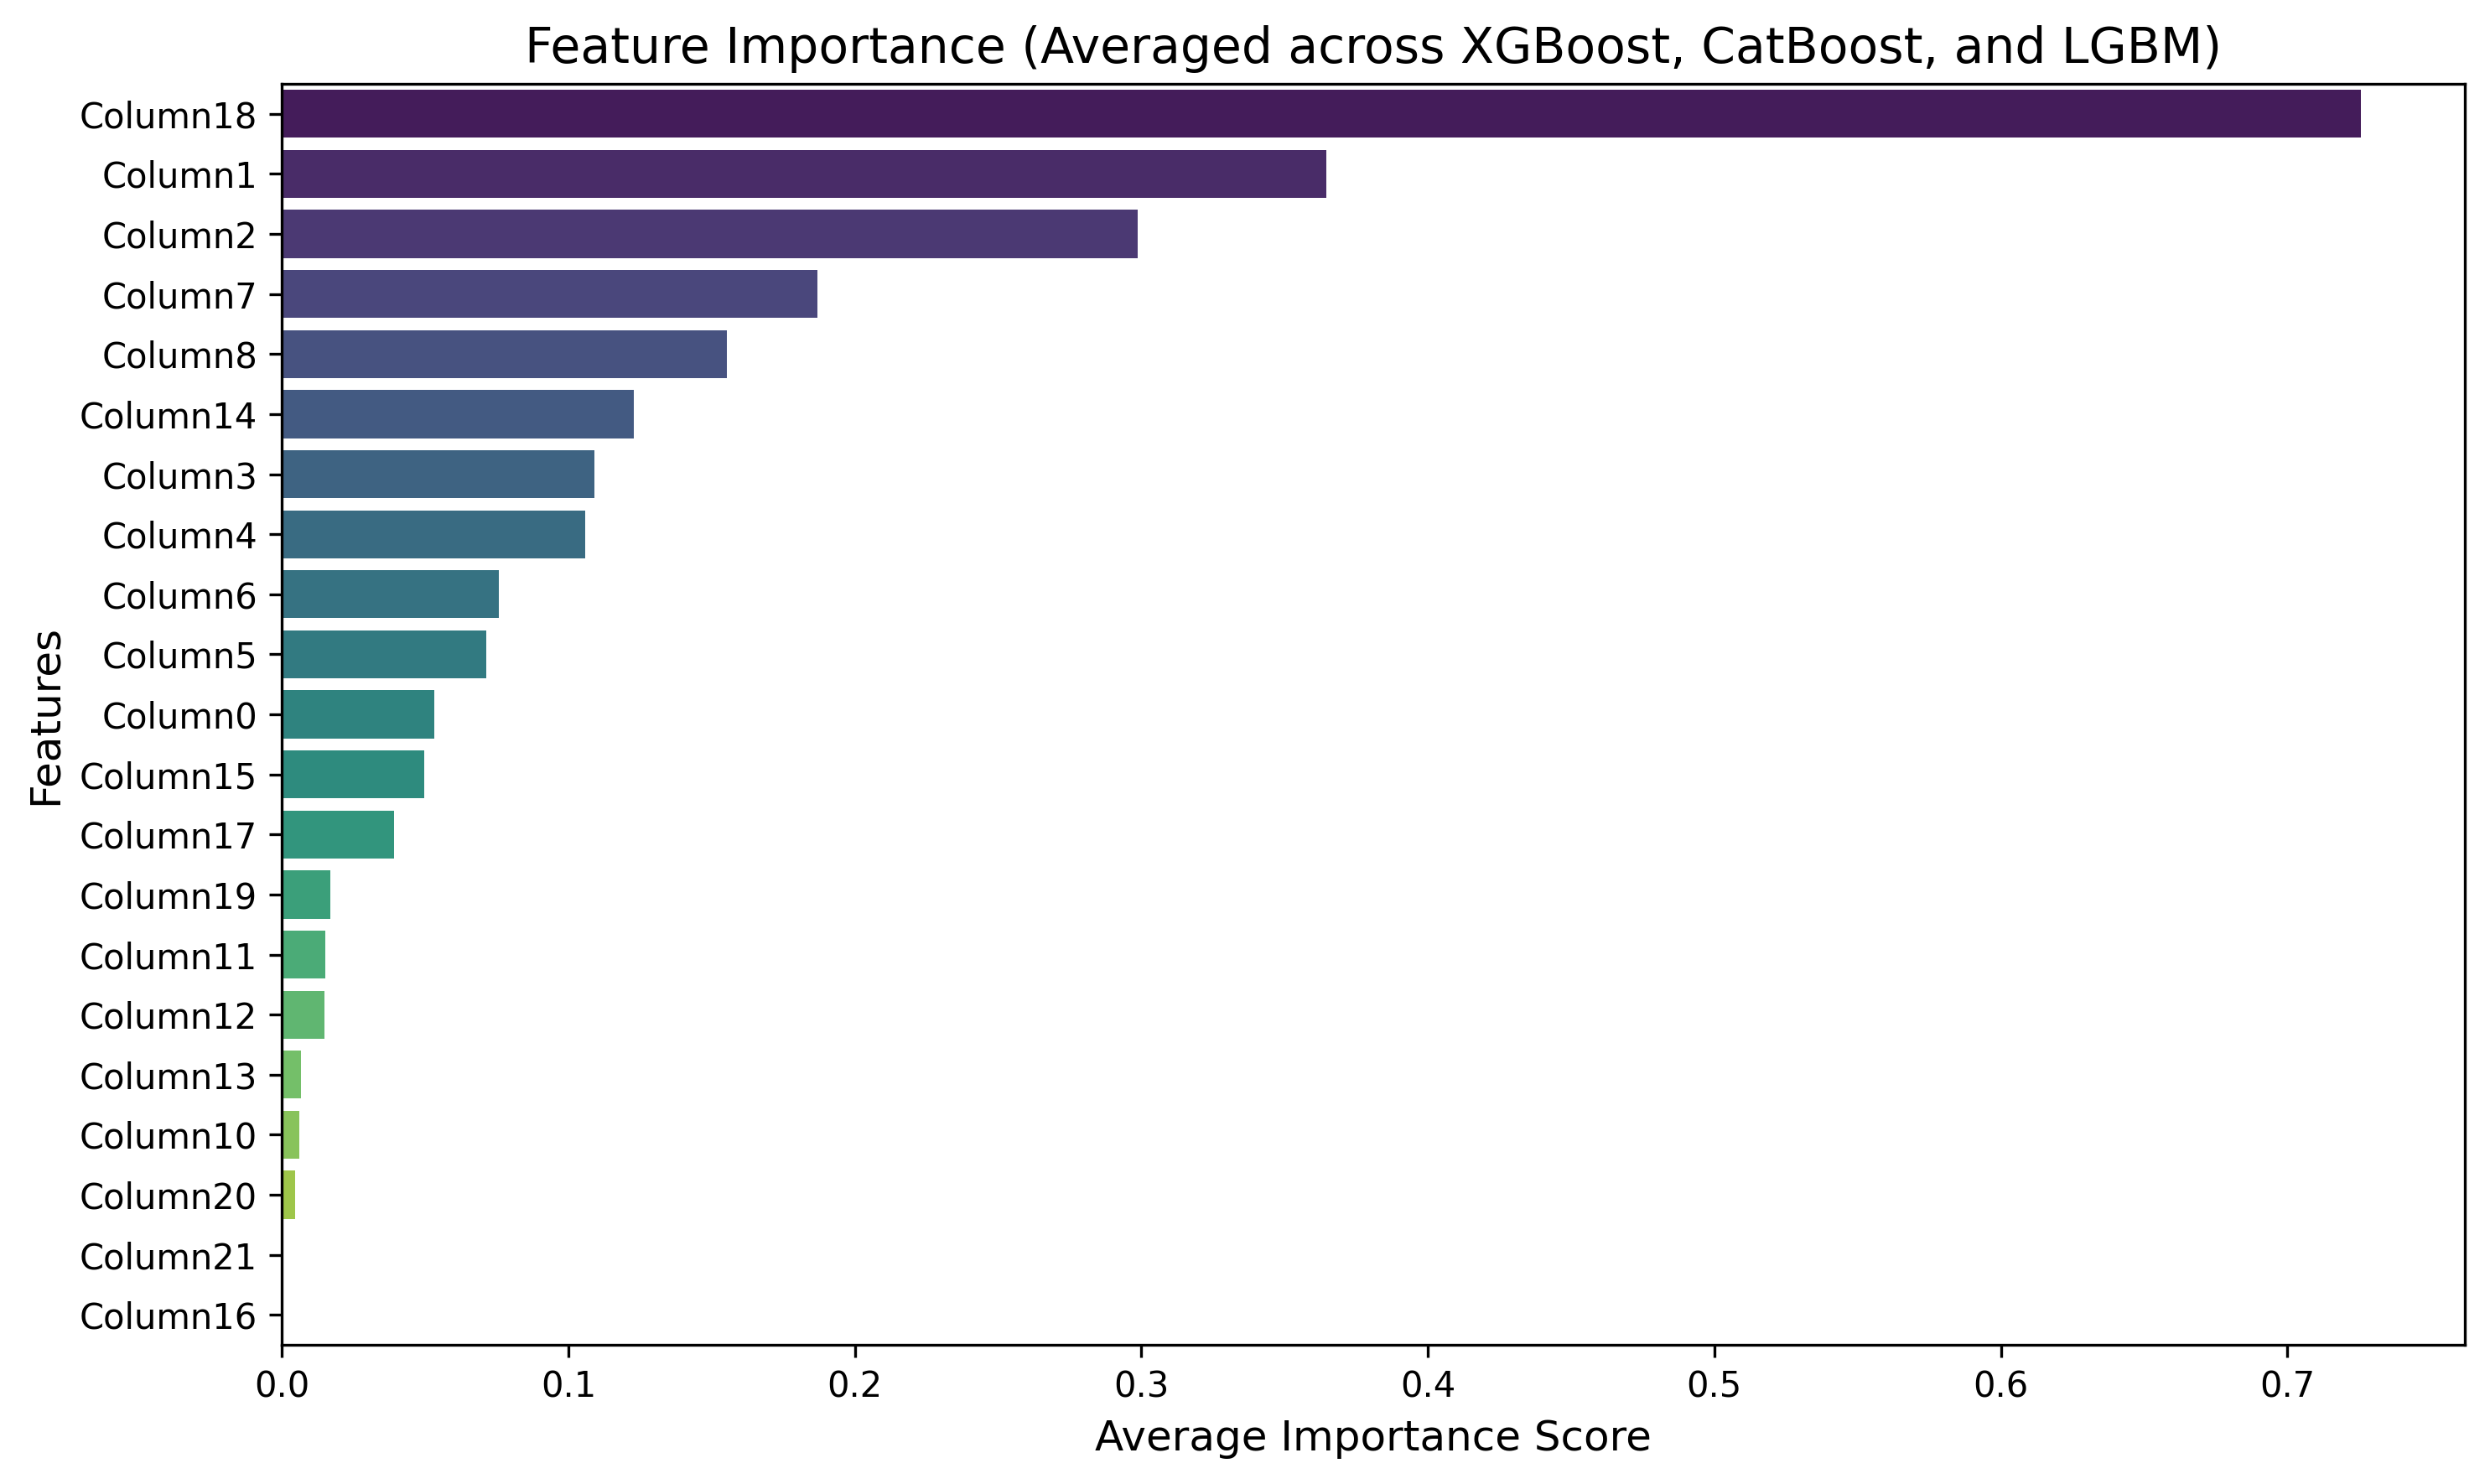

In [85]:
# Step 1: Plot the feature importance using Seaborn's barplot
plt.figure(figsize=(10, 6), dpi = 300)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

# Step 2: Add titles and labels
plt.title('Feature Importance (Averaged across XGBoost, CatBoost, and LGBM)', fontsize=14)
plt.xlabel('Average Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Step 3: Show the plot
plt.tight_layout()
plt.show()

# Graphical Representation Of Results

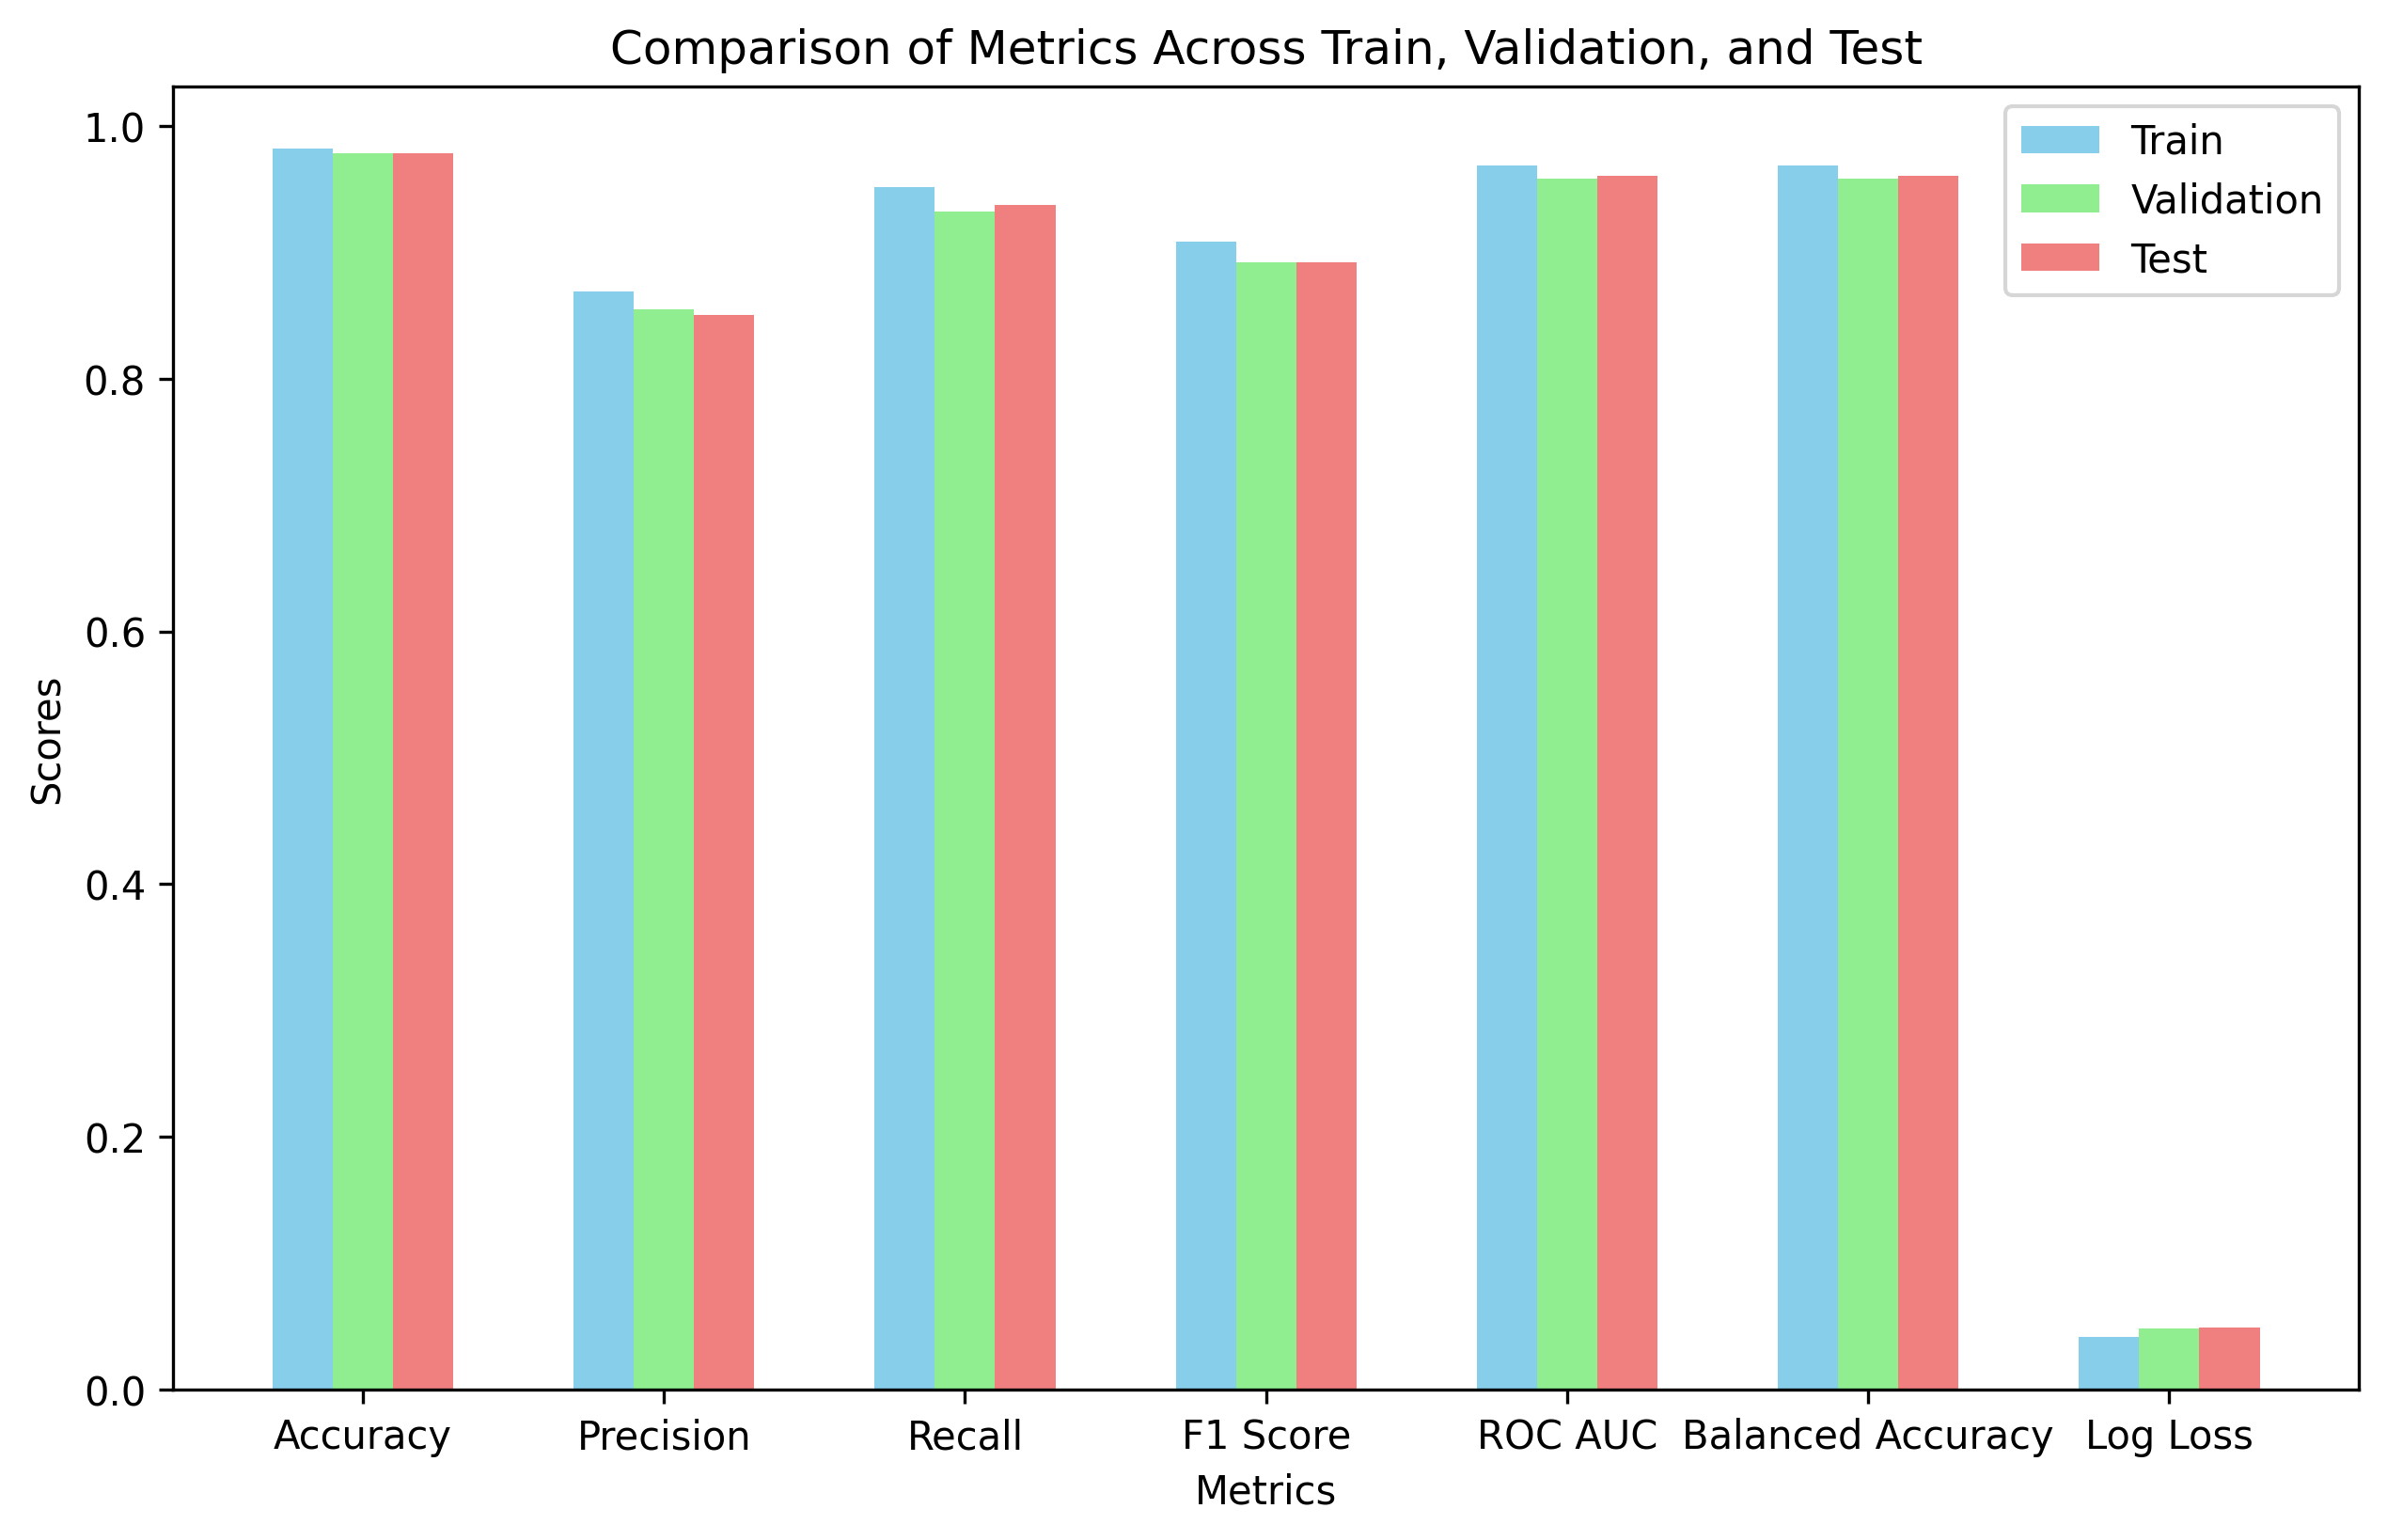

In [86]:
# Define metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Balanced Accuracy', 'Log Loss']
train_scores = [accuracy_train, precision_train, recall_train, f1_train, roc_auc_train, balanced_acc_train, log_loss_train]
val_scores = [accuracy_val, precision_val, recall_val, f1_val, roc_auc_val, balanced_acc_val, log_loss_val]
test_scores = [accuracy_test, precision_test, recall_test, f1_test, roc_auc_test, balanced_acc_test, log_loss_test]

# Plot the bar graph
plt.figure(figsize=(10, 6), dpi = 300)
x = np.arange(len(metrics))
width = 0.2

plt.bar(x - width, train_scores, width, label='Train', color='skyblue')
plt.bar(x, val_scores, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_scores, width, label='Test', color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Metrics Across Train, Validation, and Test')
plt.xticks(x, metrics)
plt.legend()
plt.show()

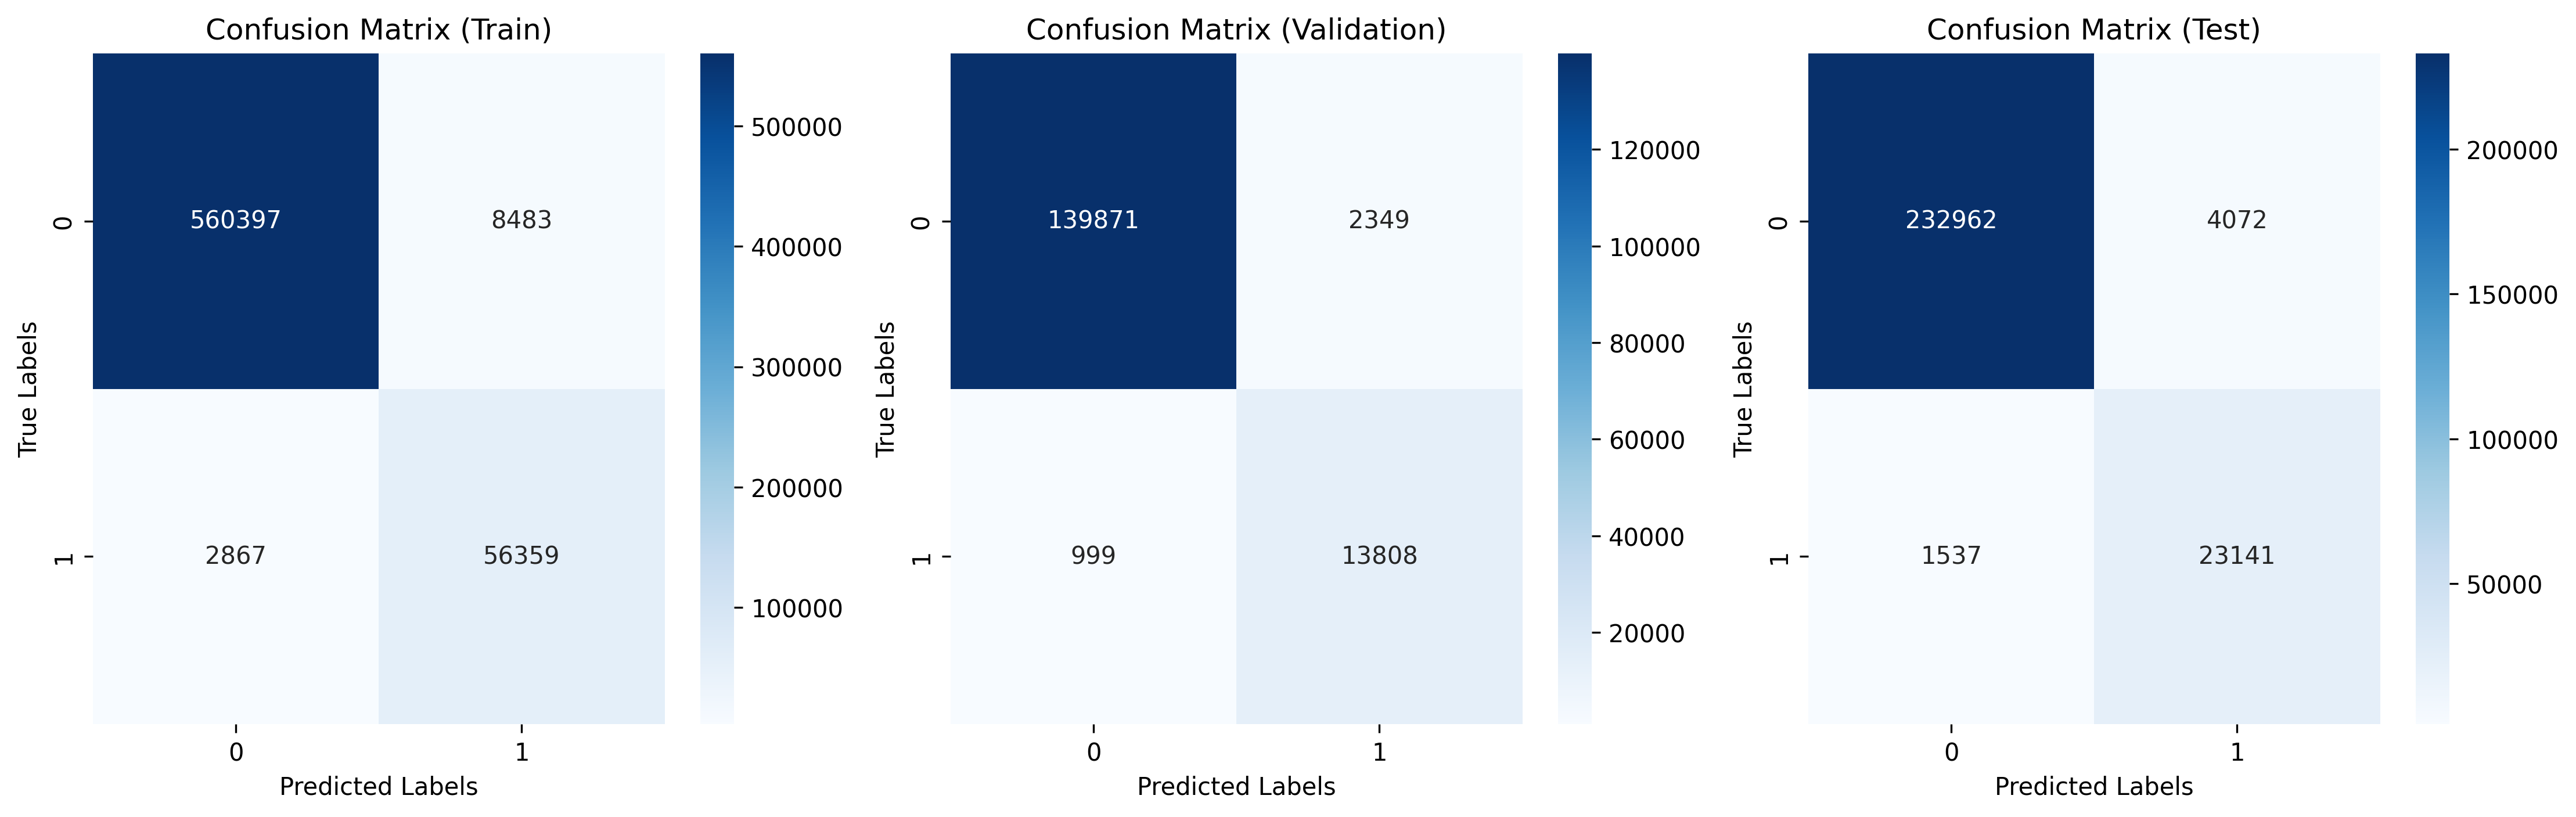

In [87]:
# Plot confusion matrices for Train, Validation, and Test data
fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi = 300)

sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Train)')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Validation)')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', ax=ax[2])
ax[2].set_title('Confusion Matrix (Test)')
ax[2].set_xlabel('Predicted Labels')
ax[2].set_ylabel('True Labels')

plt.show()

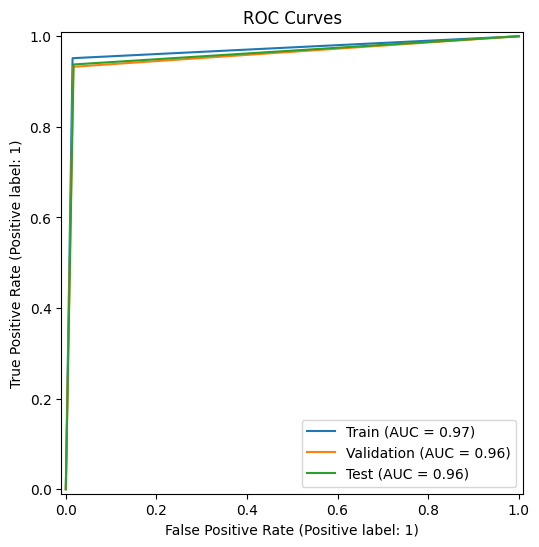

In [88]:
# Plot ROC curves for Train, Validation, and Test data
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

RocCurveDisplay.from_predictions(y_train_final['target'], y_pred_train, ax=ax, name='Train')
RocCurveDisplay.from_predictions(y_val_final['target'], y_pred_val, ax=ax, name='Validation')
RocCurveDisplay.from_predictions(y_test_final['target'], y_pred_test_final, ax=ax, name='Test')

ax.set_title('ROC Curves')
plt.show()

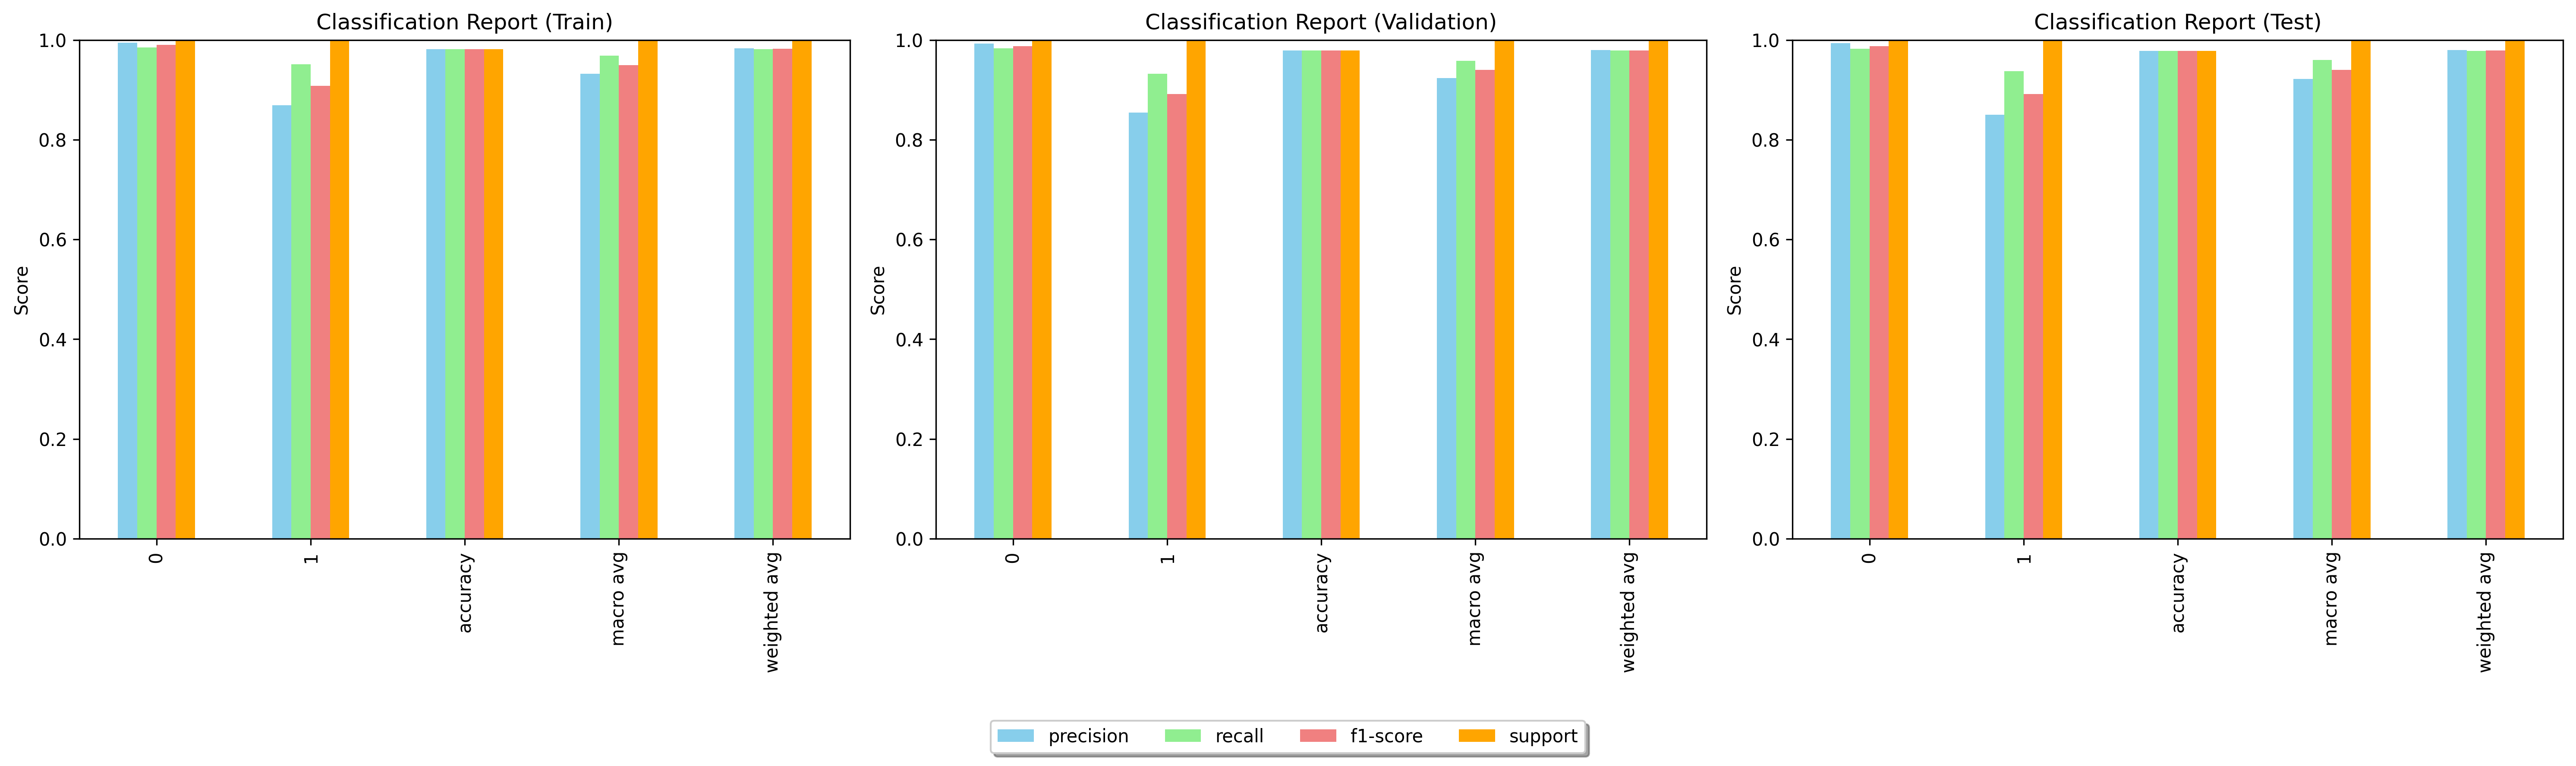

In [89]:
# Convert classification report string to DataFrame with output_dict=True
train_report = pd.DataFrame(classification_report(y_train_final['target'], y_pred_train, output_dict=True)).transpose()
val_report = pd.DataFrame(classification_report(y_val_final['target'], y_pred_val, output_dict=True)).transpose()
test_report = pd.DataFrame(classification_report(y_test_final['target'], y_pred_test_final, output_dict=True)).transpose()

# Plot Classification Report for each class (Train, Validation, Test)
fig, ax = plt.subplots(1, 3, figsize=(20, 6), dpi = 300)

# List of metrics to plot
metrics = ['precision', 'recall', 'f1-score', 'support']

# Add 'weighted avg' and 'support' to the bar plot
train_report[['precision', 'recall', 'f1-score', 'support']].plot(kind='bar', ax=ax[0], color=['skyblue', 'lightgreen', 'lightcoral', 'orange'], legend=False)
ax[0].set_title('Classification Report (Train)')
ax[0].set_ylim([0, 1])  # Support can be on a different scale, consider normalizing if needed
ax[0].set_ylabel('Score')

val_report[['precision', 'recall', 'f1-score', 'support']].plot(kind='bar', ax=ax[1], color=['skyblue', 'lightgreen', 'lightcoral', 'orange'], legend=False)
ax[1].set_title('Classification Report (Validation)')
ax[1].set_ylim([0, 1])  # Same here
ax[1].set_ylabel('Score')

test_report[['precision', 'recall', 'f1-score', 'support']].plot(kind='bar', ax=ax[2], color=['skyblue', 'lightgreen', 'lightcoral', 'orange'], legend=False)
ax[2].set_title('Classification Report (Test)')
ax[2].set_ylim([0, 1])  # Same here
ax[2].set_ylabel('Score')

# Add a common legend below the subplots
fig.legend(metrics, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01), fancybox=True, shadow=True)

# Adjust the layout to prevent overlap
plt.tight_layout(rect=[0, 0.1, 1, 1])  # This rect argument allows space for the legend
plt.show()